### N-gram model

- 현재 단어를 볼 때, 직전의 N-1 개의 단어만 보고, 다음 단어의 확률을 계산 함
- 문장을 확률로 다루는 가장 고전적인 방법이고, 이 때 까지는 단어를 벡터로 바꾸는 기술은 없었었다.
  - Unigram (N=1): 이전 문맥 없이 단어 빈도만 봄
  - Bigram (N=2): 직전 1개 단어만 봄
  - Trigram (N=3): 직전 2개 단어만 봄
- 구현이 매우 빠르고 간단하다.
- 대신 정확도는 많이 떨어진다.


### N-gram model 예시
 - 나는 오늘 학교에 간다 를 띄어쓰기 기준으로 보면,
 - ["나는", "오늘", "학교에", "간다"]
 - Unigram (N=1)
   - P("간다") = 단어 "간다"가 전체에서 등장한 비율
 - Bigram (N=2)
   - P("학교에" | "오늘")
   - P("간다" | "학교에")
 - Trigram (N=3)
   - P("학교에" | "나는", "오늘")
   - P("간다" | "오늘", "학교에")

### PPL (Perplexity)
 - 모델이 얼마나 헷갈려하는지를 나타내는 지표
 - PPL 이 낮을 수록, 다음 단어를 헷갈려하지 않고 잘 예측하는 모델이라고 생각할 수 있다.
 - 모델이 문장을 예측할 때 평균적으로 몇 개의 선택지 앞에서 고민하고 있는지를 수치로 표현한 것이라고 볼 수 있다.
 - 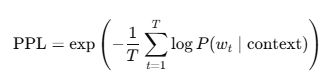

In [32]:
from huggingface_hub import HfApi, hf_hub_download
import os

repo_id = "teneriffa/kowikitext-20240301"
api = HfApi()

files = api.list_repo_files(repo_id, repo_type="dataset")
len(files), files[:20]

save_dir = "../kowikitext_dataset"
os.makedirs(save_dir, exist_ok=True)

downloaded = []

for fname in files:
    try:
        path = hf_hub_download(
            repo_id=repo_id,
            repo_type="dataset",
            filename=fname,
            local_dir=save_dir,
            local_dir_use_symlinks=False, 
        )
        downloaded.append(path)
        print(f"[OK] {fname}")
    except Exception as e:
        print(f"[FAIL] {fname} -> {e}")

print(f"\n총 다운로드 파일 수: {len(downloaded)}")


c:\Users\chech\Desktop\machine_learning_study\machine_learning_venv\Lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


[OK] .gitattributes
[OK] README.md
[OK] kowikitext_20240301.dev
[OK] kowikitext_20240301.test
[OK] kowikitext_20240301.train.zip

총 다운로드 파일 수: 5


In [33]:
import zipfile

zip_path = os.path.join(save_dir, "kowikitext_20240301.train.zip")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(save_dir)

os.remove(zip_path)

print("압축 해제 완료 & zip 삭제")

압축 해제 완료 & zip 삭제


In [34]:
import re

def normalize_spaces(text):
    return re.sub(r"\s+", " ", text).strip()

def load_and_clean_txt(path):
    cleaned = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = normalize_spaces(line)
            if not line:
                continue
            cleaned.append(line)
    return cleaned

train_texts = load_and_clean_txt("../kowikitext_dataset/kowikitext_20240301.train")
valid_texts = load_and_clean_txt("../kowikitext_dataset/kowikitext_20240301.dev")
test_texts  = load_and_clean_txt("../kowikitext_dataset/kowikitext_20240301.test")

len(train_texts), len(valid_texts), len(test_texts)

(15068050, 76378, 74630)

In [35]:
# 공백으로 토큰화
def whitespace_tokenize(text):
    text = re.sub(r"\s+", " ", text).strip()
    return text.split(" ") if text else []

def build_tokens(texts, max_lines=100_000, max_tokens=500_000):
    tokens = []
    for line in texts[:max_lines]:
        tokens.extend(whitespace_tokenize(line))
        if len(tokens) >= max_tokens:
            break
    return tokens

train_tokens = build_tokens(train_texts)
len(train_tokens), train_tokens[:20]

(500001,
 ['=',
  '틀:원소',
  '정보/헬륨',
  '=',
  '=',
  '분류:세기별',
  '탄자니아',
  '사람',
  '=',
  '=',
  'Eva',
  '(나이트위시의',
  '노래)',
  '=',
  'Eva는',
  '2007년',
  '5월',
  '25일에',
  '발매된',
  '나이트위시의'])

In [36]:
from collections import Counter
import math

class NGramLM:
    def __init__(self, n, alpha=1.0):
        self.n = n
        self.alpha = alpha
        self.ngram = Counter()
        self.context = Counter()
        self.vocab = set()

    def fit(self, tokens):
        self.vocab = set(tokens)
        pad = ["<s>"] * (self.n - 1)
        tokens = pad + tokens + ["</s>"]

        for i in range(len(tokens) - self.n + 1):
            g = tuple(tokens[i:i+self.n])
            c = g[:-1]
            self.ngram[g] += 1
            self.context[c] += 1

    def prob(self, ngram):
        c = ngram[:-1]
        V = max(len(self.vocab), 1)
        return (self.ngram[ngram] + self.alpha) / (self.context[c] + self.alpha * V)

    def sent_logprob(self, tokens):
        pad = ["<s>"] * (self.n - 1)
        tokens = pad + tokens + ["</s>"]

        logp, N = 0.0, 0
        for i in range(len(tokens) - self.n + 1):
            g = tuple(tokens[i:i+self.n])
            logp += math.log(self.prob(g))
            N += 1
        return logp, N

In [37]:
def perplexity(model, texts, max_lines=20_000):
    total_logp, total_N = 0.0, 0

    for line in texts[:max_lines]:
        tokens = whitespace_tokenize(line)
        if not tokens:
            continue
        logp, N = model.sent_logprob(tokens)
        total_logp += logp
        total_N += N

    return math.exp(-total_logp / total_N)


In [38]:
for n in [1, 2, 3]:
    lm = NGramLM(n)
    lm.fit(train_tokens)

    ppl = perplexity(lm, valid_texts)
    print(f"{n}-gram PPL: {ppl:.2f}")

1-gram PPL: 51188.54
2-gram PPL: 96787.73
3-gram PPL: 138439.01


In [39]:
import pickle
import os

def save_ngram_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump({
            "n": model.n,
            "alpha": model.alpha,
            "ngram": model.ngram,
            "context": model.context,
            "vocab": model.vocab,
        }, f)

def load_ngram_model(path):
    with open(path, "rb") as f:
        data = pickle.load(f)

    model = NGramLM(data["n"], data["alpha"])
    model.ngram = data["ngram"]
    model.context = data["context"]
    model.vocab = data["vocab"]
    return model

In [40]:
lm = NGramLM(n=2)   # bigram
lm.fit(train_tokens)

save_ngram_model(lm, "./models/bigram_ngram.pkl")

In [41]:
import json

def save_top_ngrams(model, top_k=1000, path="top_ngrams.json"):
    items = model.ngram.most_common(top_k)
    readable = {
        " ".join(k): v for k, v in items
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(readable, f, ensure_ascii=False, indent=2)

save_top_ngrams(lm, top_k=50, path="./models/bigram_top50.json")